In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from model.model import GTN
from utils.utils import f1_score, true_positive_rate, false_positive_rate
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
epochs = 50
node_dim = 64
num_channels = 2
lr = 0.005
weight_decay = 0.001
num_layers = 2
norm = True
adaptive_lr = True

In [3]:
dataset = "DBLP"

In [4]:
with open('data/'+dataset+'/node_features.pkl', 'rb') as f:
    node_features = pickle.load(f)
with open('data/'+dataset+'/edges.pkl', 'rb') as f:
    edges = pickle.load(f)
with open('data/'+dataset+'/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

/tmp/ipykernel_2753671/2598945757.py:4: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  edges = pickle.load(f)
/tmp/ipykernel_2753671/2598945757.py:4: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  edges = pickle.load(f)


In [5]:
node_features.shape


(18405, 334)

In [6]:
edges

[<18405x18405 sparse matrix of type '<class 'numpy.int64'>'
 	with 19645 stored elements in Compressed Sparse Row format>,
 <18405x18405 sparse matrix of type '<class 'numpy.int64'>'
 	with 19645 stored elements in Compressed Sparse Column format>,
 <18405x18405 sparse matrix of type '<class 'numpy.int64'>'
 	with 14328 stored elements in Compressed Sparse Row format>,
 <18405x18405 sparse matrix of type '<class 'numpy.int64'>'
 	with 14328 stored elements in Compressed Sparse Column format>]

In [7]:
labels

[[[0, 1],
  [1, 3],
  [2, 0],
  [3, 3],
  [4, 0],
  [5, 0],
  [6, 3],
  [7, 3],
  [8, 2],
  [9, 0],
  [10, 2],
  [11, 0],
  [12, 0],
  [13, 0],
  [14, 1],
  [15, 2],
  [16, 3],
  [17, 0],
  [18, 2],
  [19, 3],
  [20, 0],
  [21, 1],
  [22, 2],
  [23, 2],
  [24, 2],
  [25, 2],
  [26, 2],
  [27, 2],
  [28, 0],
  [29, 1],
  [30, 0],
  [31, 0],
  [32, 1],
  [33, 2],
  [34, 2],
  [35, 3],
  [36, 3],
  [37, 2],
  [38, 3],
  [39, 0],
  [40, 3],
  [41, 2],
  [42, 1],
  [43, 2],
  [44, 1],
  [45, 0],
  [46, 0],
  [47, 1],
  [48, 0],
  [49, 1],
  [50, 1],
  [51, 2],
  [52, 3],
  [53, 3],
  [54, 2],
  [55, 2],
  [56, 3],
  [57, 1],
  [58, 3],
  [59, 2],
  [60, 0],
  [61, 1],
  [62, 1],
  [63, 3],
  [64, 3],
  [65, 2],
  [66, 2],
  [67, 2],
  [68, 1],
  [69, 1],
  [70, 2],
  [71, 3],
  [72, 0],
  [73, 0],
  [74, 0],
  [75, 1],
  [76, 0],
  [77, 3],
  [78, 0],
  [79, 0],
  [80, 1],
  [81, 0],
  [82, 1],
  [83, 2],
  [84, 2],
  [85, 3],
  [86, 0],
  [87, 3],
  [88, 0],
  [89, 0],
  [90, 2],
  [91, 3]

In [8]:
num_nodes = edges[0].shape[0]

for i,edge in enumerate(edges):
    if i ==0:
        A = torch.from_numpy(edge.todense()).type(torch.FloatTensor).unsqueeze(-1)
    else:
        A = torch.cat([A,torch.from_numpy(edge.todense()).type(torch.FloatTensor).unsqueeze(-1)], dim=-1)
A = torch.cat([A,torch.eye(num_nodes).type(torch.FloatTensor).unsqueeze(-1)], dim=-1)

In [9]:
node_features = torch.from_numpy(node_features).type(torch.FloatTensor)
train_node = torch.from_numpy(np.array(labels[0])[:,0]).type(torch.LongTensor)
train_target = torch.from_numpy(np.array(labels[0])[:,1]).type(torch.LongTensor)
valid_node = torch.from_numpy(np.array(labels[1])[:,0]).type(torch.LongTensor)
valid_target = torch.from_numpy(np.array(labels[1])[:,1]).type(torch.LongTensor)
test_node = torch.from_numpy(np.array(labels[2])[:,0]).type(torch.LongTensor)
test_target = torch.from_numpy(np.array(labels[2])[:,1]).type(torch.LongTensor)


In [10]:
num_classes = torch.max(train_target).item()+1
final_f1 = 0

model = GTN(num_edge=A.shape[-1],
            num_channels=num_channels,
            w_in=node_features.shape[1],
            w_out=node_dim,
            num_class=num_classes,
            num_layers=num_layers,
            norm=norm)
if adaptive_lr == 'false':
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
else:
    optimizer = torch.optim.Adam([{'params': model.weight},
                                  {'params': model.linear1.parameters()},
                                  {'params': model.linear2.parameters()},
                                  {"params": model.layers.parameters(), "lr": 0.5}
                                  ], lr=0.005, weight_decay=0.001)
loss = nn.CrossEntropyLoss()

In [11]:
# Train & Valid & Test
best_val_loss = 10000
best_test_loss = 10000
best_train_loss = 10000
best_train_f1 = 0
best_val_f1 = 0
best_test_f1 = 0
valloss =[]
testloss =[]
trainloss =[]
trainf1=[]
testf1=[]
valf1=[]
train_tpr=[]
train_fpr=[]
val_tpr=[]
val_fpr=[]
test_tpr=[]
test_fpr=[]

In [12]:
for i in range(epochs):
    for param_group in optimizer.param_groups:
        if param_group['lr'] > 0.005:
             param_group['lr'] = param_group['lr'] * 0.9
    print('Epoch:  ',i+1)
    model.zero_grad()
    model.train()
    loss,y_train,Ws = model(A, node_features, train_node, train_target)
    train_f1 = torch.mean(f1_score(torch.argmax(y_train.detach(),dim=1), train_target, num_classes=num_classes)).cpu().numpy()
    trainloss.append(loss.detach().cpu().numpy())
    trainf1.append(train_f1)
    train_tpr.append(torch.mean(true_positive_rate(torch.argmax(y_train.detach(),dim=1), train_target, num_classes=num_classes)).cpu().numpy())
    train_fpr.append(torch.mean(false_positive_rate(torch.argmax(y_train.detach(),dim=1), train_target, num_classes=num_classes)).cpu().numpy())
    print('Train - Loss: {}, Macro_F1: {}'.format(loss.detach().cpu().numpy(), train_f1))
    loss.backward()
    optimizer.step()
    model.eval()
    # Valid
    with torch.no_grad():
        val_loss, y_valid,_ = model.forward(A, node_features, valid_node, valid_target)
        val_f1 = torch.mean(f1_score(torch.argmax(y_valid,dim=1), valid_target, num_classes=num_classes)).cpu().numpy()
        valloss.append(val_loss.detach().cpu().numpy())
        valf1.append(val_f1)
        val_tpr.append(torch.mean(true_positive_rate(torch.argmax(y_valid.detach(),dim=1), valid_target, num_classes=num_classes)).cpu().numpy())
        val_fpr.append(torch.mean(false_positive_rate(torch.argmax(y_valid.detach(),dim=1), valid_target, num_classes=num_classes)).cpu().numpy())
        print('Valid - Loss: {}, Macro_F1: {}'.format(val_loss.detach().cpu().numpy(), val_f1))
        test_loss, y_test,W = model.forward(A, node_features, test_node, test_target)
        test_f1 = torch.mean(f1_score(torch.argmax(y_test,dim=1), test_target, num_classes=num_classes)).cpu().numpy()
        testloss.append(test_loss.detach().cpu().numpy())
        testf1.append(test_f1)
        test_tpr.append(torch.mean(true_positive_rate(torch.argmax(y_test.detach(),dim=1), test_target, num_classes=num_classes)).cpu().numpy())
        test_fpr.append(torch.mean(false_positive_rate(torch.argmax(y_test.detach(),dim=1), test_target, num_classes=num_classes)).cpu().numpy())
        print('Test - Loss: {}, Macro_F1: {}\n'.format(test_loss.detach().cpu().numpy(), test_f1))
        if val_f1 > best_val_f1:
            best_val_loss = val_loss.detach().cpu().numpy()
            best_test_loss = test_loss.detach().cpu().numpy()
            best_train_loss = loss.detach().cpu().numpy()
            best_train_f1 = train_f1
            best_val_f1 = val_f1
            best_test_f1 = test_f1

print('---------------Best Results--------------------')
print('Train - Loss: {}, Macro_F1: {}'.format(best_train_loss, best_train_f1))
print('Valid - Loss: {}, Macro_F1: {}'.format(best_val_loss, best_val_f1))
print('Test - Loss: {}, Macro_F1: {}'.format(best_test_loss, best_test_f1))
final_f1 += best_test_f1

Epoch:   1
Train - Loss: 1.3874698877334595, Macro_F1: 0.09959959983825684
Valid - Loss: 1.3693199157714844, Macro_F1: 0.15237632393836975
Test - Loss: 1.3756414651870728, Macro_F1: 0.11961409449577332

Epoch:   2
Train - Loss: 1.3675531148910522, Macro_F1: 0.17955073714256287
Valid - Loss: 1.335802435874939, Macro_F1: 0.6227450370788574
Test - Loss: 1.3378465175628662, Macro_F1: 0.6191526651382446

Epoch:   3
Train - Loss: 1.331876516342163, Macro_F1: 0.6637651920318604
Valid - Loss: 1.2675817012786865, Macro_F1: 0.6627408862113953
Test - Loss: 1.2647048234939575, Macro_F1: 0.6347707509994507

Epoch:   4
Train - Loss: 1.2617313861846924, Macro_F1: 0.6661398410797119
Valid - Loss: 1.1430717706680298, Macro_F1: 0.7761111855506897
Test - Loss: 1.1460850238800049, Macro_F1: 0.7417622208595276

Epoch:   5
Train - Loss: 1.1364496946334839, Macro_F1: 0.7572315335273743
Valid - Loss: 0.9707363843917847, Macro_F1: 0.9198579788208008
Test - Loss: 0.9773195385932922, Macro_F1: 0.8989477157592773

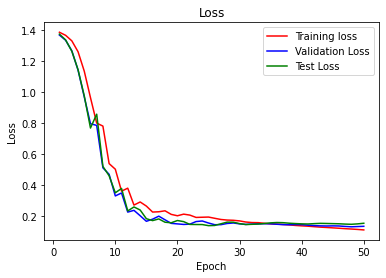

In [13]:
x = np.linspace(1,epochs)
plt.plot(x,trainloss,'r-',label="Training loss")
plt.plot(x,valloss,'b-',label="Validation Loss")
plt.plot(x,testloss,'g-',label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

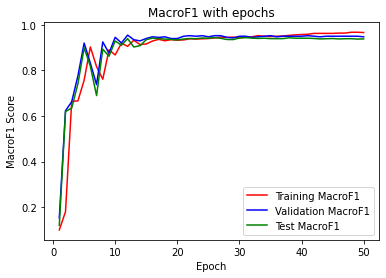

In [14]:
x = np.linspace(1,epochs)
plt.plot(x,trainf1,'r-',label="Training MacroF1")
plt.plot(x,valf1,'b-',label="Validation MacroF1")
plt.plot(x,testf1,'g-',label="Test MacroF1")
plt.title("MacroF1 with epochs")
plt.xlabel("Epoch")
plt.ylabel("MacroF1 Score")
plt.legend()
plt.show()